In [1]:
!pwd

/home/bit/Desktop/Project/Event Detection


In [2]:
!nvidia-smi

Fri Dec 10 10:52:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.86       Driver Version: 470.86       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:09:00.0  On |                  N/A |
| 37%   64C    P2   127W / 350W |  14577MiB / 24259MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install -q -U watermark
!pip install -qq transformers
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.29.0

numpy       : 1.20.3
pandas      : 1.3.4
torch       : 1.10.0
transformers: 4.7.0



In [4]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, AutoTokenizer, AutoModelForSequenceClassification
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import f1_score

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

# RANDOM_SEED = 42
# np.random.seed(RANDOM_SEED)
# torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# New Section

In [5]:
from transformers import BertTokenizer,BertModel
# PRE_TRAINED_MODEL_NAME = "hfl/chinese-roberta-wwm-ext"
# PRE_TRAINED_MODEL_NAME = "hfl/chinese-roberta-wwm-ext-large"
# PRE_TRAINED_MODEL_NAME = "hfl/chinese-bert-wwm-ext"
PRE_TRAINED_MODEL_NAME = "bert-base-uncased"
# PRE_TRAINED_MODEL_NAME = "ProsusAI/finbert"
# PRE_TRAINED_MODEL_NAME = "bert-base-chinese"
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME,do_lower_case=True)

In [7]:
# data = pd.read_csv('/home/bit/Desktop/Project/data/Event Detection - Annotations of current database.csv',encoding='latin')
# data = data.sample(frac=1)
# data = data.reset_index(drop=True)

In [8]:
# dictionary={}
# data = data.fillna(0)
# for col in data.columns[2:12]:
#     a = list(data[col].unique())
#     a.remove(0)
#     dictionary[col]=a[0]
#     data.loc[data[col]!=0,col]=1
# data = data.rename(columns=dictionary)
# print(data.columns[2:12])

Index(['cancer journey', 'qum', 'health inequity/disparity',
       'patient centricity', 'phc', 'innovation/innovative therapies',
       'affordability', 'initiatives/education', 'timely access',
       'advocary/reform'],
      dtype='object')


In [9]:
# data = data.sample(frac=1)
# data = data.reset_index(drop=True)
# df_train = data.loc[0:int(0.8*len(data))]
# df_val = data.loc[int(0.8*len(data)):int(0.9*len(data))]
# df_test = data.loc[int(0.9*len(data)):]

# df_train.to_csv('/home/bit/Desktop/Project/data/ed_train.csv',sep='\t',index=None)
# df_val.to_csv('/home/bit/Desktop/Project/data/ed_val.csv',sep='\t',index=None)
# df_test.to_csv('/home/bit/Desktop/Project/data/ed_test.csv',sep='\t',index=None)

In [10]:
df_train = pd.read_csv('/home/bit/Desktop/Project/data/ed_train.csv',encoding='latin',sep='\t')
df_val = pd.read_csv('/home/bit/Desktop/Project/data/ed_val.csv',encoding='latin',sep='\t')
df_test = pd.read_csv('/home/bit/Desktop/Project/data/ed_test.csv',encoding='latin',sep='\t')

In [11]:
df_train = df_train.fillna(0)
df_val = df_val.fillna(0)
df_test = df_test.fillna(0)


In [12]:
def label_digitalise(data):
    dictionary={}
    for col in data.columns[2:12]:
#         a = list(data[col].unique())
#         a.remove(0)
#         dictionary[col]=a[0]
        data.loc[data[col]!=0,col]=1
#     data.rename(columns=dictionary)
    return data

df_train = label_digitalise(df_train)
df_test = label_digitalise(df_test)
df_val = label_digitalise(df_val)

In [13]:
# sns.distplot(token_lens)
# plt.xlabel('Token count')

In [14]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target)
    }

In [25]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text.to_numpy(),
    targets=df.iloc[:,2:12].values.tolist(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [67]:
BATCH_SIZE = 16
max_len = 300
class_names = ['cancer journey', 'qum', 'health inequity/disparity', 'patient centricity', 'phc', 'innovation/innovative therapies','affordability', 'initiatives/education', 'timely access','advocary/reform']


train_data_loader = create_data_loader(df_train, tokenizer, max_len, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, max_len, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, max_len, BATCH_SIZE)

In [28]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.1)
    self.sig = nn.Sigmoid()
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )[1]
    
    output = self.drop(pooled_output)
    # # output = self.L1(output)
    output = self.out(pooled_output)
#     output = self.sig(output)
 
    return output

In [29]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
# data = next(iter(train_data_loader))
# data.keys()

In [31]:
# input_ids = data['input_ids'].to(device)
# attention_mask = data['attention_mask'].to(device)
# print(input_ids.shape) # batch size x seq length
# print(attention_mask.shape) # batch size x seq length

In [32]:
# model(input_ids,attention_mask)

In [33]:
EPOCHS = 30

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.BCEWithLogitsLoss().to(device)

In [34]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    for pred, label in zip(outputs.cpu(), targets.cpu()):
#       print(pred,label)
      seq_tags = set(list(np.where(pred > 0)[0]))
#       print(seq_tags)
      label = label.cpu().numpy()
      label = set(list(np.where(label == 1)[0]))
#       print(label)
      if seq_tags == label:
        correct_predictions += 1


    loss = loss_fn(outputs, targets.float())
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return float(correct_predictions) / n_examples, np.mean(losses)

In [35]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      
      if outputs.dim()==1:
        outputs = torch.unsqueeze(outputs,0)
      for pred, label in zip(outputs.cpu(), targets.cpu()):
        seq_tags = set(list(np.where(pred > 0)[0]))
        label = label.cpu().numpy()
        label = set(list(np.where(label == 1)[0]))
        if seq_tags == label:
          correct_predictions += 1
      
      loss = loss_fn(outputs, targets.float())
      losses.append(loss.item())

  return float(correct_predictions) / n_examples, np.mean(losses)

In [36]:
history = defaultdict(list)
best_accuracy = 0
# EPOCHS = 5

In [37]:
%%time

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'ed_best_model_state.bin')
    best_accuracy = val_acc
  torch.save(model.state_dict(), 'ed_last_model_state.bin')

Epoch 1/30
----------
Train loss 0.5384872513157981 accuracy 0.009569377990430622
Val   loss 0.4341655373573303 accuracy 0.0

Epoch 2/30
----------
Train loss 0.4289812466927937 accuracy 0.023923444976076555
Val   loss 0.40122079849243164 accuracy 0.14814814814814814

Epoch 3/30
----------
Train loss 0.38589252318654743 accuracy 0.10047846889952153
Val   loss 0.3782879263162613 accuracy 0.18518518518518517

Epoch 4/30
----------
Train loss 0.34203265607357025 accuracy 0.14354066985645933
Val   loss 0.3721715658903122 accuracy 0.2222222222222222

Epoch 5/30
----------
Train loss 0.3161159540925707 accuracy 0.215311004784689
Val   loss 0.3527398854494095 accuracy 0.2222222222222222

Epoch 6/30
----------
Train loss 0.27749297874314444 accuracy 0.291866028708134
Val   loss 0.3610536903142929 accuracy 0.2222222222222222

Epoch 7/30
----------
Train loss 0.24035460076161794 accuracy 0.4449760765550239
Val   loss 0.34354542195796967 accuracy 0.3333333333333333

Epoch 8/30
----------
Train lo

In [38]:
len(history["train_acc"])

30

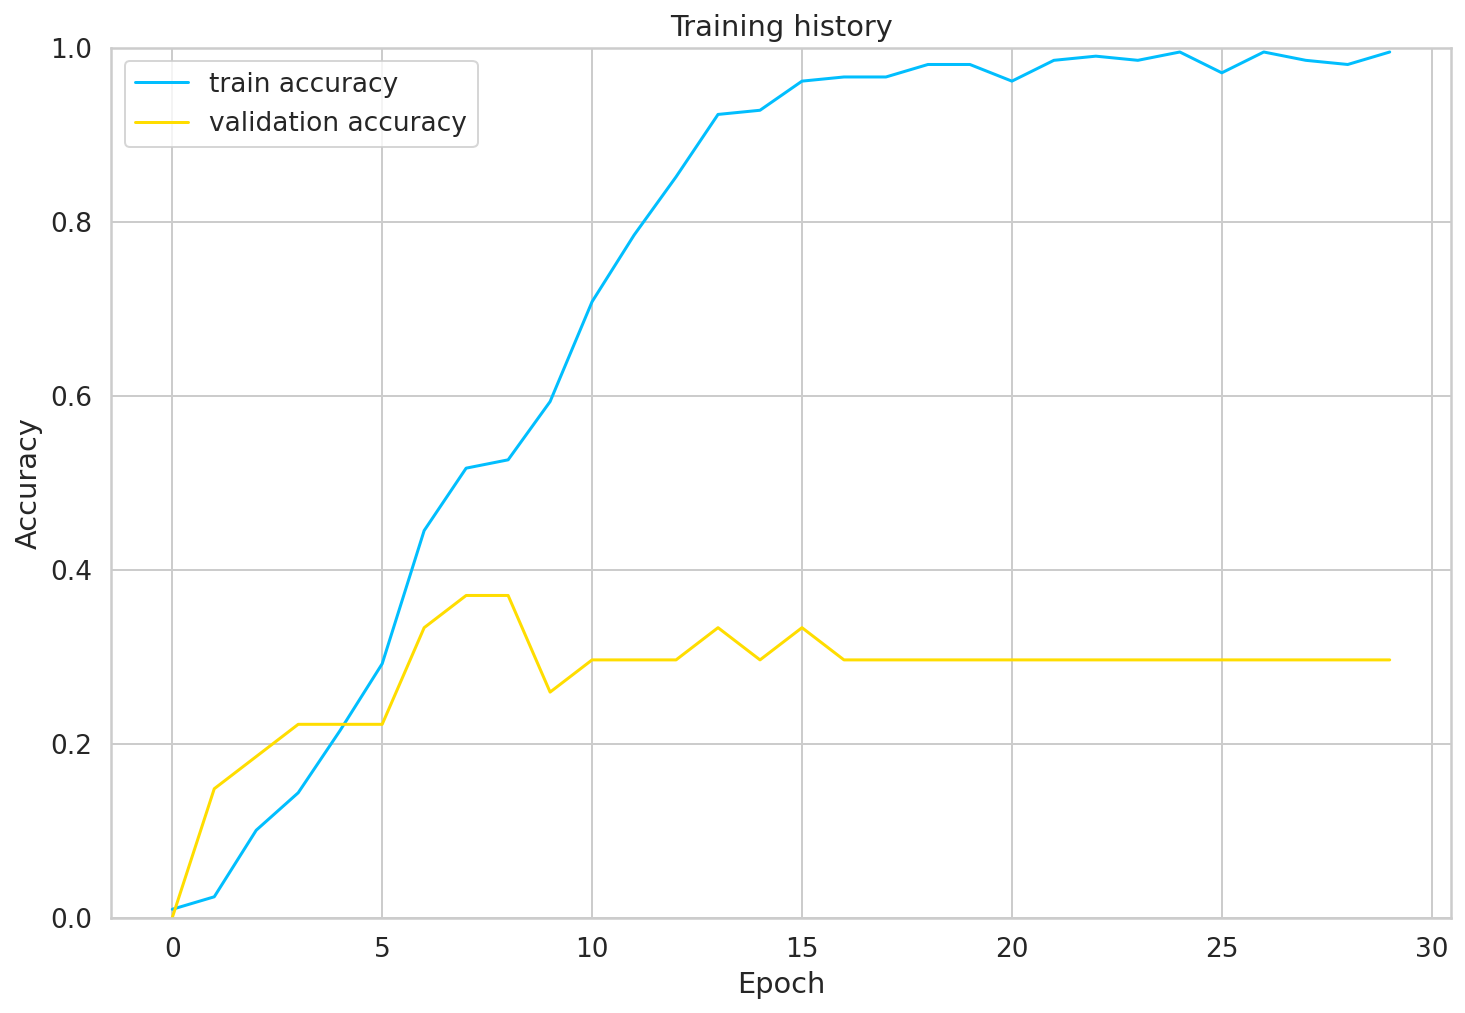

In [39]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [40]:
# tokenizer.save_vocabulary('vacab.txt')

In [41]:
# tokenizer.save_pretrained('content/drive/MyDrive/model/best_model/')

In [42]:
# model.bert.save_pretrained('best_model_state.bin')

In [43]:
# !gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA

model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('ed_best_model_state.bin'))
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [44]:
len(df_test)

26

In [45]:
# test_acc, _ = eval_model(
#   model,
#   test_data_loader,
#   loss_fn,
#   device,
#   len(df_test)
# )

# test_acc.item()

AttributeError: 'float' object has no attribute 'item'

In [65]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  outputs_list = []
  targets_list = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      if outputs.dim()==1:
        outputs = torch.unsqueeze(outputs,0)
      print(outputs)
      preds = torch.where(outputs > 0,1,0)

      review_texts.extend(texts)
      predictions.extend(preds)
      outputs_list.extend(outputs)
      targets_list.extend(targets)

  predictions = torch.stack(predictions).cpu()
  outputs_list = torch.stack(outputs_list).cpu()
  targets_list = torch.stack(targets_list).cpu()
  return review_texts, predictions, outputs_list,targets_list

In [66]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

tensor([[-4.5464, -4.1420, -2.6997, -3.5620,  2.9957, -0.8852, -3.7077, -1.9804,
         -0.8320, -1.3839],
        [-2.0860, -3.7761, -2.8200, -0.9132, -2.0418, -3.3018, -3.0454,  0.2373,
         -2.3649, -1.3017],
        [-4.3308, -4.3803, -3.1323, -3.8491,  0.0385, -2.5131, -3.3445, -1.9157,
         -1.5500, -1.0754],
        [-3.6637, -3.5653, -2.5436, -2.1258, -2.8439, -3.5363, -3.0259, -1.2829,
         -2.3353,  1.1852],
        [-2.1150, -4.2887, -3.8107, -1.2748, -1.3805, -3.3918, -3.3720,  0.3240,
         -2.7812, -1.7361],
        [-2.8002, -3.0396, -2.0708, -0.6949, -3.5488, -3.5318, -2.6951, -0.0202,
         -2.2623,  1.0305],
        [-3.3575, -4.6841, -3.7350, -2.0422, -1.6243, -3.8202, -3.6739, -0.2583,
         -2.4905, -0.8956],
        [-3.8886, -4.0726, -3.1188, -3.1965,  1.4626, -2.6339, -3.5564,  1.0323,
         -2.1157, -2.0368],
        [-3.9684, -3.5343, -2.3080, -2.6080, -1.9834, -2.8487, -2.8662, -2.2331,
         -1.7131,  1.1327],
        [-3.0506, -

In [61]:
y_test.shape

torch.Size([26, 10])

In [51]:
y_pred.shape

torch.Size([26, 10])

In [62]:
print(classification_report(y_test, y_pred, target_names=class_names,digits = 4,zero_division=0))

                                 precision    recall  f1-score   support

                 cancer journey     1.0000    0.2000    0.3333         5
                            qum     0.0000    0.0000    0.0000         0
      health inequity/disparity     0.0000    0.0000    0.0000         1
             patient centricity     1.0000    0.3333    0.5000         6
                            phc     0.9000    0.8182    0.8571        11
innovation/innovative therapies     0.0000    0.0000    0.0000         4
                  affordability     0.0000    0.0000    0.0000         1
          initiatives/education     0.5714    0.5714    0.5714         7
                  timely access     0.0000    0.0000    0.0000         2
                advocary/reform     0.8333    0.4545    0.5882        11

                      micro avg     0.8077    0.4375    0.5676        48
                      macro avg     0.4305    0.2377    0.2850        48
                   weighted avg     0.7097    0.4

In [63]:
# def show_confusion_matrix(confusion_matrix):
#   hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
#   hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
#   hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
#   plt.ylabel('True sentiment')
#   plt.xlabel('Predicted sentiment');

# cm = confusion_matrix(y_test, y_pred)
# df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
# show_confusion_matrix(df_cm)

ValueError: multilabel-indicator is not supported

In [ ]:
# !pip install lit-nlp

In [ ]:
# from lit_nlp.api.dataset import Dataset
# class MultiNLIData(Dataset):
#   """Loader for MultiNLI development set."""
#   def __init__(self, df):
#     # Read the eval set from a .tsv file as distributed with the GLUE benchmark.
#     # df = pandas.read_csv(path, sep='\t')
#     # Store as a list of dicts, conforming to self.spec()
#     self.LABELS = [0,1]
#     self._examples = [{
#       'sentence': row['DESCRIPTION_EN'],
#       # 'hypothesis': row['sentence2'],
#       'label': row['LABEL']
#       # 'genre': row['genre'],
#     } for _, row in df.iterrows()]
#   def spec(self):
#     return {
#       'sentence': lit_types.TextSegment(),
#       # 'hypothesis': lit_types.TextSegment(),
#       'label': lit_types.CategoryLabel(vocab=self.LABELS),
#       # We can include additional fields, which don't have to be used by the model.
#       # 'genre': lit_types.Label(),
#     }

In [ ]:
# from absl import app
# from absl import flags
# from absl import logging

# from lit_nlp import dev_server
# from lit_nlp import server_flags
# from lit_nlp.api import model as lit_model
# from lit_nlp.api import types as lit_types
# # Use the regular GLUE data loaders, because these are very simple already.
# from lit_nlp.examples.datasets import glue
# from lit_nlp.lib import utils

# import torch
# import transformers

# # NOTE: additional flags defined in server_flags.py

# FLAGS = flags.FLAGS

# flags.DEFINE_string(
#     "model_path",
#     "https://storage.googleapis.com/what-if-tool-resources/lit-models/sst2_tiny.tar.gz",
#     "Path to trained model, in standard transformers format, e.g. as "
#     "saved by model.save_pretrained() and tokenizer.save_pretrained()")


# def _from_pretrained(cls, *args, **kw):
#   """Load a transformers model in PyTorch, with fallback to TF2/Keras weights."""
#   try:
#     return cls.from_pretrained(*args, **kw)
#   except OSError as e:
#     logging.warning("Caught OSError loading model: %s", e)
#     logging.warning(
#         "Re-trying to convert from TensorFlow checkpoint (from_tf=True)")
#     return cls.from_pretrained(*args, from_tf=True, **kw)


# class SimpleSentimentModel(lit_model.Model):
#   """Simple sentiment analysis model."""

#   LABELS = [0,1]  # negative, positive

#   def __init__(self, model_name_or_path):
#     self.tokenizer = transformers.AutoTokenizer.from_pretrained(
#         model_name_or_path)
#     model_config = transformers.AutoConfig.from_pretrained(
#         model_name_or_path,
#         num_labels=2,
#         output_hidden_states=True,
#         output_attentions=True,
#     )
#     # This is a just a regular PyTorch model.
#     self.model = _from_pretrained(
#         transformers.AutoModelForSequenceClassification,
#         model_name_or_path,
#         config=model_config)
#     self.model.eval()

#   ##
#   # LIT API implementation
#   def max_minibatch_size(self):
#     # This tells lit_model.Model.predict() how to batch inputs to
#     # predict_minibatch().
#     # Alternately, you can just override predict() and handle batching yourself.
#     return 16

#   def predict_minibatch(self, inputs):
#     # Preprocess to ids and masks, and make the input batch.
#     encoded_input = self.tokenizer.batch_encode_plus(
#         [ex["sentence"] for ex in inputs],
#         return_tensors="pt",
#         add_special_tokens=True,
#         max_length=200,
#         padding="longest",
#         truncation="longest_first")

#     # Check and send to cuda (GPU) if available
#     if torch.cuda.is_available():
#       self.model.cuda()
#       for tensor in encoded_input:
#         encoded_input[tensor] = encoded_input[tensor].cuda()
#     # Run a forward pass.
#     with torch.no_grad():  # remove this if you need gradients.
#       out: transformers.modeling_outputs.SequenceClassifierOutput = \
#           self.model(**encoded_input)

#     # Post-process outputs.
#     batched_outputs = {
#         "probas": torch.nn.functional.softmax(out.logits, dim=-1),
#         "input_ids": encoded_input["input_ids"],
#         "ntok": torch.sum(encoded_input["attention_mask"], dim=1),
#         "cls_emb": out.hidden_states[-1][:, 0],  # last layer, first token
#     }
#     # Return as NumPy for further processing.
#     detached_outputs = {k: v.cpu().numpy() for k, v in batched_outputs.items()}
#     # Unbatch outputs so we get one record per input example.
#     for output in utils.unbatch_preds(detached_outputs):
#       ntok = output.pop("ntok")
#       output["tokens"] = self.tokenizer.convert_ids_to_tokens(
#           output.pop("input_ids")[1:ntok - 1])
#       yield output

#   def input_spec(self) -> lit_types.Spec:
#     return {
#         "sentence": lit_types.TextSegment(),
#         "label": lit_types.CategoryLabel(vocab=self.LABELS, required=False)
#     }

#   def output_spec(self) -> lit_types.Spec:
#     return {
#         "tokens": lit_types.Tokens(),
#         "probas": lit_types.MulticlassPreds(parent="label", vocab=self.LABELS),
#         "cls_emb": lit_types.Embeddings()
#     }


In [ ]:
# dataset = MultiNLIData(df_train.sample(1800))

In [ ]:
# datasets = {"sst_dev": dataset}
# models = {"sst": SimpleSentimentModel("/content/drive/MyDrive/model/best_model/")}
# # models = {"sst": SimpleSentimentModel("bert-base-uncased")}

In [ ]:
# from lit_nlp import notebook
# widget = notebook.LitWidget(models, datasets, height=800)

In [ ]:
# mm = models["sst"]

In [ ]:
# mm.model.config

In [ ]:
# widget.render()

In [ ]:
# dataset.LABELS


In [ ]:
# df.loc[df.NAME=="三角防务"]

In [ ]:
# import torch
# from torch import nn, optim
# from torch.utils.data import Dataset, DataLoader

# from transformers import BertTokenizer, BertForSequenceClassification, Trainer, BertModel


# class ModelNero:
#     def __init__(self, base_model_name, num_labels, path, max_len=300, batch_size=16):
#         self.tokenizer = BertTokenizer.from_pretrained(base_model_name)
#         self.model = SentimentClassifier(num_labels, base_model_name)
#         self.model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

#         self.max_len = max_len
#         self.batch_size = batch_size

#     def create_data_loader(self, data):
#         ds = GPReviewDataset(
#                 reviews=data,
#                 # targets=df.rating.to_numpy(),
#                 tokenizer=self.tokenizer,
#                 max_len=self.max_len
#         )

#         return DataLoader(
#                 ds,
#                 batch_size=self.batch_size,
#                 num_workers=4
#         )

#     def get_predictions(self, data_loader):
#         model = self.model.eval()

#         review_texts = []
#         predictions = []
#         prediction_probs = []
#         real_values = []

#         with torch.no_grad():
#             for d in data_loader:
#                 texts = d["review_text"]
#                 # input_ids = d["input_ids"].to(device)
#                 # attention_mask = d["attention_mask"].to(device)
#                 # targets = d["targets"].to(device)

#                 # outputs = model(
#                 #         input_ids=input_ids,
#                 #         attention_mask=attention_mask
#                 # )
#                 outputs = model(
#                         input_ids=d["input_ids"],
#                         attention_mask=d["attention_mask"]
#                 )

#                 _, preds = torch.max(outputs, dim=1)

#                 # probs = F.softmax(outputs, dim=1)
#                 #
#                 # review_texts.extend(texts)
#                 predictions.extend(preds)
#                 # prediction_probs.extend(probs)
#                 # real_values.extend(targets)
#         return predictions


# class GPReviewDataset(Dataset):

#     def __init__(self, reviews, tokenizer, max_len):
#         self.reviews = reviews
#         # self.targets = targets
#         self.tokenizer = tokenizer
#         self.max_len = max_len

#     def __len__(self):
#         return len(self.reviews)

#     def __getitem__(self, item):
#         review = str(self.reviews[item])
#         # target = self.targets[item]

#         encoding = self.tokenizer.encode_plus(
#                 review,
#                 add_special_tokens=True,
#                 max_length=self.max_len,
#                 return_token_type_ids=False,
#                 padding='max_length',
#                 truncation=True,
#                 return_attention_mask=True,
#                 return_tensors='pt',
#         )

#         return {
#             'review_text'   : review,
#             'input_ids'     : encoding['input_ids'].flatten(),
#             'attention_mask': encoding['attention_mask'].flatten(),
#             # 'targets'       : torch.tensor(target, dtype=torch.long)
#         }


# class SentimentClassifier(nn.Module):

#     def __init__(self, n_classes, model_name):
#         super(SentimentClassifier, self).__init__()
#         self.bert = BertModel.from_pretrained(model_name)
#         # self.drop = nn.Dropout(p=0.1)
#         # self.relu = nn.ReLU()
#         # self.L1 = nn.Linear(self.bert.config.hidden_size,self.bert.config.hidden_size//2)
#         self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

#     def forward(self, input_ids, attention_mask):
#         pooled_output = self.bert(
#                 input_ids=input_ids,
#                 attention_mask=attention_mask
#         )[1]

#         # output = self.drop(pooled_output)
#         # # output = self.L1(output)
#         output = self.out(pooled_output)

#         return output


# if __name__ == '__main__':
#     base_model_name = "bert-base-uncased"
#     num_labels = 3
#     path = "/content/drive/MyDrive/project/model_last/last_model_state.bin"
#     model = ModelNero(base_model_name, num_labels, path)

#     allData = ['this pizza is good', 'this pizza looks like shit']
#     dataLoader = model.create_data_loader(allData)
#     preds = model.get_predictions(dataLoader)
#     print(preds)